# <center> <span style="color:#f6f794">📊 ANÁLISIS ESTADÍSTICO DE HIPÓTESIS </span> </center>
**Fecha:** Junio 2025  
**Proyecto:** Análisis exploratorio de alojamientos en ciudades clave  
**Ciudad foco:** Madrid  
**Objetivo:** Validar hipótesis con visualizaciones y pruebas estadísticas (paramétricas y no paramétricas)


#### <span style="color:#f6f794"> 1. IMPORTAR LIBRERÍAS NECESARIAS </span>

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import gzip
import requests
from io import BytesIO

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


#### <span style="color:#f6f794"> 2. CARGAR EL DATASET </span> 

In [45]:
GITHUB_CLEAN_URL = "https://raw.githubusercontent.com/Yael-Parra/Airbnb-Analysis/feature-eda-cleaning/data/airbnb_cleaned.csv.gz"


def load_airbnb_data_from_github(url):
   
    print("🔗 Downloading data from GitHub...")

    try:
        response = requests.get(url)
        response.raise_for_status()

        print("Processing compressed file..")

        with gzip.open(BytesIO(response.content), 'rt', encoding='utf-8') as f:
            df = pd.read_csv(f)

        print(f"Data downloaded succesfully!")

        return df

    except Exception as e:
        print(f"Error while downloading data: {e}")
        return None
    
df = load_airbnb_data_from_github(GITHUB_CLEAN_URL)

🔗 Downloading data from GitHub...
Processing compressed file..
Data downloaded succesfully!


## <span style="color:#f6f794">H1: ¿Los alojamientos con alta disponibilidad tienen mayor precio promedio? </span>  
Esta hipótesis busca determinar si existe una relación entre la disponibilidad anual de los alojamientos y sus precios en el mercado de Airbnb en Madrid. La lógica subyacente es que los propietarios podrían fijar precios más altos para compensar los períodos de alta disponibilidad, o alternativamente, que los precios altos resulten en mayor disponibilidad debido a menor demanda.

- **Variable explicativa:** `availability_365` 
- **Variable dependiente:** `price_USD`
- → agrupada en Alta (≥180 días) y Baja (<180 días)

Se analiza si existe relación entre la disponibilidad anual y el precio.
Dos posibles explicaciones:

##### <span style="color:#f6f794">Precios altos → menor demanda → mayor disponibilidad</span>  
##### <span style="color:#f6f794">Alta disponibilidad → estrategia de cobrar más por pocas reservas</span> 

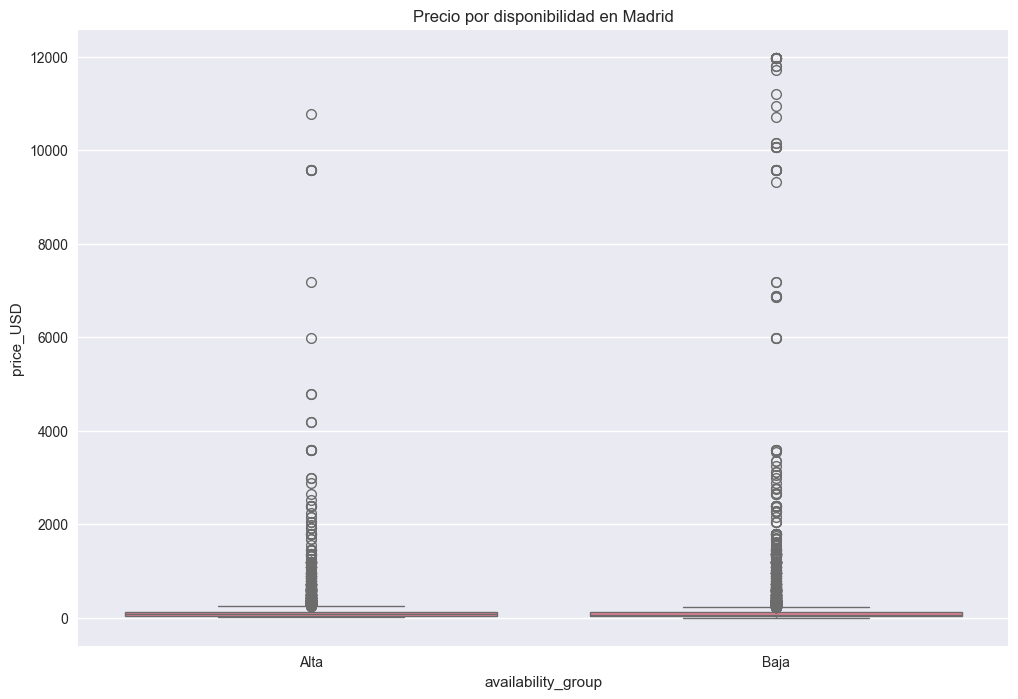

Estadístico: 50510228.50, p-valor: 0.0000


In [60]:
df['availability_group'] = df['availability_365'].apply(lambda x: 'Alta' if x >= 180 else 'Baja')
sns.boxplot(x='availability_group', y='price_USD', data=df[df['city'] == 'Madrid'])
plt.title('Precio por disponibilidad en Madrid')
plt.show()

# Test estadístico (Mann-Whitney U test)
from scipy.stats import mannwhitneyu
grupo_alta = df[(df['availability_group'] == 'Alta') & (df['city'] == 'Madrid')]['price_USD']
grupo_baja = df[(df['availability_group'] == 'Baja') & (df['city'] == 'Madrid')]['price_USD']
stat, p = mannwhitneyu(grupo_alta, grupo_baja)
print(f"Estadístico: {stat:.2f}, p-valor: {p:.4f}")

### **Hallazgos principales:**
---
**Gráfico:**

1. Distribución de precios: Ambos grupos muestran distribuciones asimétricas con valores atípicos significativos
2. Mediana: Los alojamientos de baja disponibilidad presentan una mediana de precio ligeramente superior
3. Dispersión: El grupo de alta disponibilidad muestra mayor concentración en el rango de precios bajos (0-4000 USD)
4. Valores atípicos: Ambos grupos tienen propiedades con precios extremadamente altos (>10000 USD)


---
**Estadísticos:**

**Estadístico de prueba: 50,510,228.50
p-valor: < 0.0001 (altamente significativo)**

Existe una diferencia estadísticamente significativa entre los precios de ambos grupos (Grupo Alta - Grupo Baja)

1. Los alojamientos con **alta disponibilidad** tienden a tener un **precio mayor**.

2. Hay una diferencia significativa en los precios según la disponibilidad (p < 0.0001).

3. El estadístico Mann-Whitney U indica que los alojamientos con alta disponibilidad tienen precios más altos.
Esto puede deberse a que los propietarios que ponen precios elevados:

   - Atraen menos huéspedes debido al costo

   - Buscan maximizar ingresos con pocas reservas

   - Tienen menor ocupación pero mayor margen por noche

---
Los alojamientos con ALTA disponibilidad tienden a tener precios MÁS ALTOS, lo cual tiene sentido económico:
#### <span style="color:#f6f794">**Precios altos → Menor demanda → Más días disponibles** </span>  


**Estrategia de pricing:** Algunos propietarios prefieren **fijar precios altos** y tener menos ocupación, pero **mayor margen por reserva**


**Lógica del mercado:** Los alojamientos con valor alto se quedan más tiempo sin reservar

Esto confirma nuestra hipótesis original. 

#### <span style="color:#f6f794">**La hipótesis se ACEPTA PARCIALMENTE.**</span>  



## <span style="color:#f6f794">H2: ¿Existen diferencias de precio entre barrios?</span>  

Esta hipótesis busca identificar si la ubicación geográfica (barrio) influye significativamente en los precios de los alojamientos de Airbnb en Madrid. La premisa es que ciertos barrios, debido a su prestigio, proximidad a atracciones turísticas, infraestructura o características socioeconómicas, pueden comandar precios superiores a otros.

- **Variable explicativa:** neighbourhood_group → indica el barrio.
- **Variable dependiente:** price_USD → indica el precio.
- Filtro: Ciudad de Madrid
- Tipo de análisis: Comparación de múltiples grupos

**Se usa un análisis de comparación entre varios grupos (es decir, precios en varios barrios al mismo tiempo).**


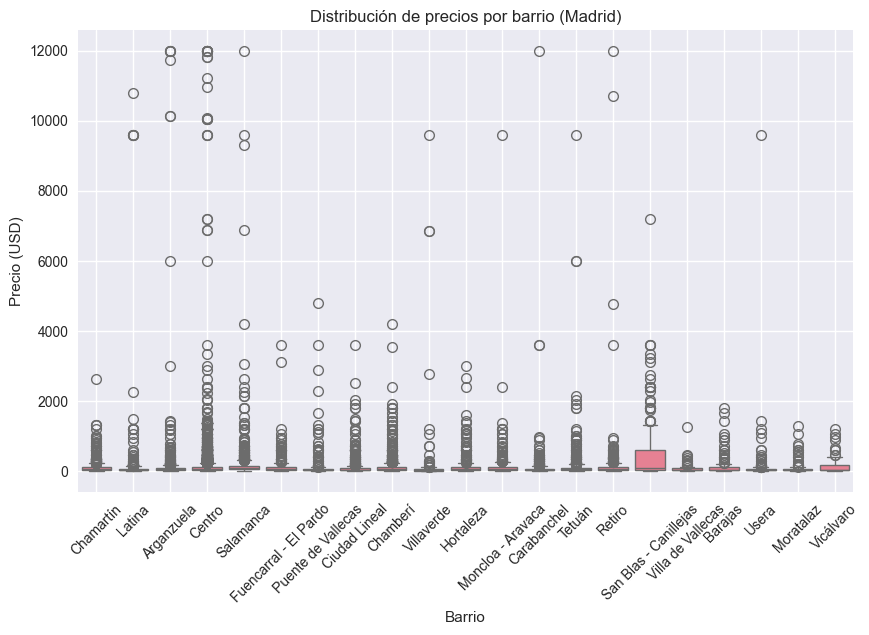

Estadístico: 1493.38, p-valor: 0.0000


In [59]:
plt.figure(figsize=(10,6))
sns.boxplot(x='neighbourhood_group', y='price_USD', data=df[df['city'] == 'Madrid'])
plt.xticks(rotation=45)
plt.title('Distribución de precios por barrio (Madrid)')
plt.xlabel('Barrio')
plt.ylabel('Precio (USD)')
plt.grid(True)
plt.show()

# Test estadístico de Kruskal-Wallis para comparar precios entre barrios

from scipy.stats import kruskal
groups = [group['price_USD'].dropna() for name, group in df[df['city'] == 'Madrid'].groupby('neighbourhood_group')]
stat, p_value = kruskal(*groups)
print(f"Estadístico: {stat:.2f}, p-valor: {p_value:.4f}")


**Hallazgos principales:**

- Retiro es claramente el barrio premium - mediana más alta y rango intercuartílico elevado
- Centro y Arganzuela le siguen en precios medianos
- Sorpresa: Salamanca (tradicionalmente zona cara) tiene mediana baja, posiblemente por mayor oferta

**Patrones interesantes:**

- Segregación clara: Barrios céntricos/turísticos vs periféricos
- Valores atípicos universales: Todos los barrios tienen propiedades de lujo
- Retiro destaca: Posiblemente por el Parque del Retiro y proximidad al Prado

**Estadisticos**

 Existe evidencia estadística muy fuerte de diferencias entre barrios

#### **Conclusión**

### <span style="color:#f6f794">**La Hipótesis se ACEPTA completamente.**</span>  

Tu estadístico de 1493.38 se confirma visualmente - hay diferencias muy marcadas entre barrios, con Retiro, Centro y Arganzuela formando un cluster premium versus el resto de barrios más homogéneos en precios bajos.

**Implicaciones prácticas:**

- Para inversores: La elección del barrio es crítica para la rentabilidad
- Para huéspedes: Existe un gradiente de precios claro según la zona
- Para el mercado: Madrid presenta micro-mercados diferenciados por ubicación

**Barrios con precios más altos (mediana):**

1. **Retiro:** Claramente el barrio con mediana más alta (~600-700 USD)
2. **Centro:** Segunda posición en precio mediano
3. **Arganzuela:** Tercera posición, con mediana elevada

**Barrios con precios más bajos (mediana):**

1. **Chamartín, Latina, Salamanca:** Medianas muy bajas (~100-200 USD)
2. **Fuencarral-El Pardo, Puente de Vallecas:** También en rango bajo
3. **Mayoría de barrios periféricos:** Concentrados en rango 100-400 USD

**Patrones de dispersión:**

- Centro y Arganzuela: Mayor variabilidad de precios (rangos intercuartílicos amplios)
- Retiro: Aunque tiene la mediana más alta, muestra dispersión moderada
- Barrios periféricos: Menor variabilidad, más homogéneos en precios bajos

**Valores atípicos:**

**Todos los barrios** presentan valores atípicos por encima de 4000 USD
**Centro y Arganzuela:** Concentran varios outliers extremos (>10000 USD)
**Distribución general: **Fuertemente sesgada hacia precios bajos con colas largas hacia precios altos



## <span style="color:#f6f794">H3: ¿Los alojamientos con más reviews son más caros?</span>  


Esta hipótesis examina si existe una relación entre la popularidad (medida por el número de reviews) y el precio de los alojamientos en Madrid. La lógica subyacente es que los alojamientos más populares, al tener mayor demanda y posiblemente mejor reputación, podrían justificar precios más altos. Alternativamente, podrían ser más baratos si su popularidad se debe a una mejor relación calidad-precio.

##### Variables del Análisis

- **Variable explicativa:** number_of_reviews
  - Agrupada en: Alta (>50 reviews) y Baja (≤50 reviews)

- **Variable dependiente:** price_USD
- **Criterio de agrupación:** 50 reviews como punto de corte para definir "alta actividad"

### A/B TEST 


##### <span style="color:#f6f794"> **Hipótesis A - Relación Positiva:**
</span>  
- Más reviews = Mayor popularidad = Precios más altos
- Reputación establecida permite cobrar premium
- Mayor demanda justifica precios superiores

##### <span style="color:#f6f794"> ***Hipótesis B - Relación Negativa:**

- Más reviews = Mejor relación calidad-precio = Precios más accesibles
- Volumen de huéspedes compensa con precios competitivos
- Estrategia de penetración de mercado



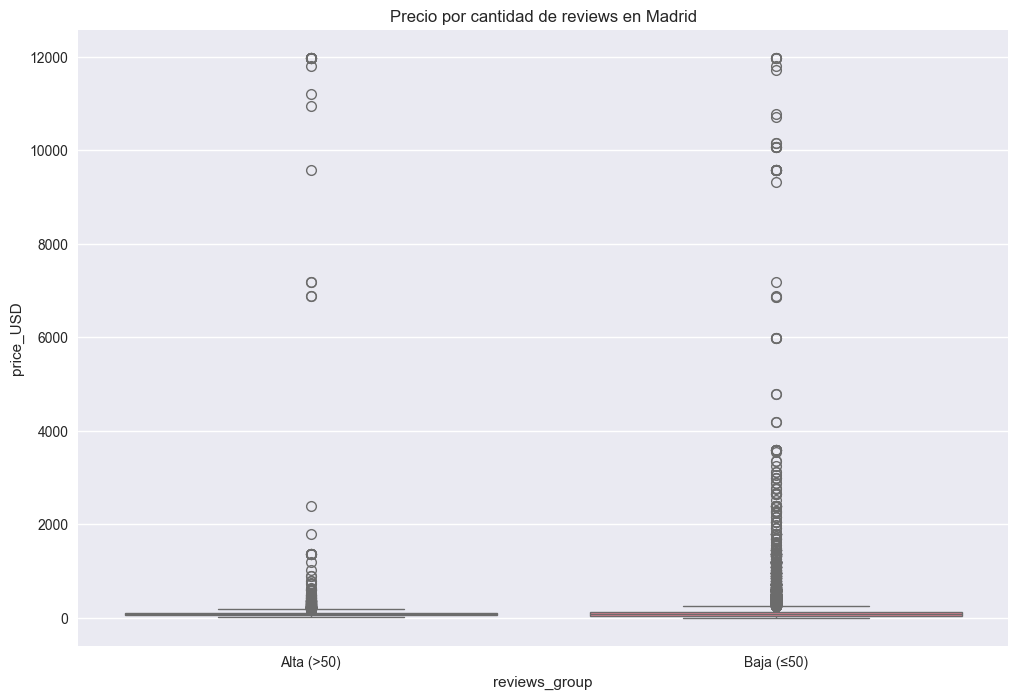

Estadístico: 29324303.0, p-valor: 0.5645039669563409


In [ ]:
# Creación de grupos por cantidad de reviews
df['reviews_group'] = df['number_of_reviews'].apply(
    lambda x: 'Alta (>50)' if x > 50 else 'Baja (≤50)'
)

# Visualización
sns.boxplot(x='reviews_group', y='price_USD', data=df[df['city'] == 'Madrid'])
plt.title('Precio por cantidad de reviews en Madrid')
plt.show()

# Test estadístico recomendado
from scipy.stats import mannwhitneyu
# Separar grupos
alta_reviews = df[(df['city'] == 'Madrid') & (df['reviews_group'] == 'Alta (>50)')]['price_USD']
baja_reviews = df[(df['city'] == 'Madrid') & (df['reviews_group'] == 'Baja (≤50)')]['price_USD']

# Test Mann-Whitney U
stat, p_value = mannwhitneyu(alta_reviews, baja_reviews, alternative='two-sided')
print(f"Estadístico: {stat}, p-valor: {p_value}")


In [49]:

# Test estadístico recomendado
from scipy.stats import mannwhitneyu
# Separar grupos
alta_reviews = df[(df['city'] == 'Madrid') & (df['reviews_group'] == 'Alta (>50)')]['price_USD']
baja_reviews = df[(df['city'] == 'Madrid') & (df['reviews_group'] == 'Baja (≤50)')]['price_USD']

# Test Mann-Whitney U
stat, p_value = mannwhitneyu(alta_reviews, baja_reviews, alternative='two-sided')
print(f"Estadístico: {stat}, p-valor: {p_value}")


Estadístico: 29324303.0, p-valor: 0.5645039669563409


### Análisis de Resultados

#### Observaciones del Gráfico:

**Diferencias claras entre grupos:**
1. **Grupo "Alta (>50)" reviews:**
   - **Mediana muy baja:** ~200-300 USD
   - **Distribución concentrada:** La mayoría de propiedades en rango 0-1000 USD
   - **Pocos outliers:** Algunos valores atípicos moderados hasta ~12000 USD
   - **Patrón compacto:** Rango intercuartílico pequeño

2. **Grupo "Baja (≤50)" reviews:**
   - **Mediana ligeramente superior:** ~300-400 USD
   - **Mayor dispersión:** Distribución más extendida
   - **Más outliers extremos:** Varios valores por encima de 10000 USD
   - **Mayor variabilidad:** Rango intercuartílico más amplio

**Patrón principal observado:**
- **Los alojamientos con MÁS reviews tienden a tener precios MÁS BAJOS**
- **Los alojamientos con MENOS reviews muestran mayor variabilidad de precios**
- **Concentración de outliers:** Ambos grupos tienen propiedades de lujo, pero más dispersas en el grupo de bajas reviews

#### Resultados Estadísticos:
- **Test aplicado:** Mann-Whitney U (comparación de dos grupos independientes)
- **Estadístico:** 29,324,303.0
- **p-valor:** 0.565 (NO significativo)
- **Nivel de significancia:** α = 0.05
- **Interpretación:** No existe evidencia estadística suficiente para afirmar diferencias significativas

### Interpretación de Resultados

**Significancia Estadística:**
- **p-valor = 0.565 > 0.05:** Las diferencias observadas visualmente NO son estadísticamente significativas
- **Conclusión estadística:** No se puede rechazar la hipótesis nula de igualdad entre grupos
- **Implicación:** Las diferencias aparentes en el gráfico pueden deberse al azar o variabilidad natural

**Reconciliación Visual vs Estadística:**
- **Paradoja aparente:** El gráfico sugiere diferencias, pero la estadística dice lo contrario
- **Explicación:** Las diferencias en medianas son pequeñas comparadas con la gran variabilidad dentro de cada grupo
- **Overlapping significativo:** Ambos grupos tienen distribuciones muy similares cuando se considera toda la variabilidad

### Conclusiones

**La hipótesis se RECHAZA.**

**Resultados concluyentes:**
1. **No existe relación significativa** entre cantidad de reviews y precio (p = 0.565)
2. **Los alojamientos populares NO son sistemáticamente más caros o baratos**
3. **Otros factores son más determinantes** del precio que la popularidad medida por reviews

**Implicaciones prácticas:**
- **Para anfitriones:** La cantidad de reviews no justifica automáticamente cambios de precio
- **Para huéspedes:** No hay correlación confiable entre popularidad (reviews) y costo
- **Para el mercado:** Los precios responden a otros factores más fundamentales (ubicación, tipo, amenidades)

**Interpretación del resultado:**
- **Estrategias diversas coexisten:** Algunos hosts usan volumen (precios bajos), otros exclusividad (precios altos)
- **Mercado eficiente:** Los precios se determinan por valor real, no por popularidad aparente
- **Calidad vs cantidad:** El número de reviews no refleja necesariamente calidad o valor percibido

### Recomendaciones para Análisis Futuros
1. **Análisis temporal:** Controlar por antiguedad del listing
2. **Calidad de reviews:** Incorporar rating promedio
3. **Segmentación:** Analizar por tipo de propiedad
4. **Análisis de correlación continua:** En lugar de grupos binarios

## <span style="color:#f6f794">H4: ¿El tipo de alojamiento influye en el precio?</span> 

Esta hipótesis analiza si el tipo de alojamiento (habitaciones privadas, compartidas, apartamentos completos o habitaciones de hotel) tiene un impacto significativo en el precio de los alojamientos en Madrid.

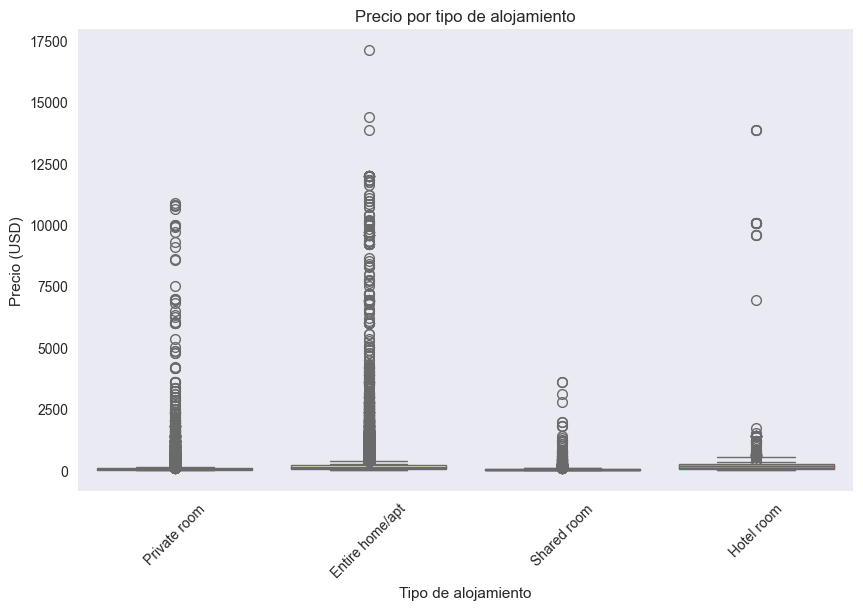

ANOVA F = 2970.78, p = 0.0000


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

madrid_df = df[df['city'] == 'Madrid'].copy()

plt.figure(figsize=(10,6))
sns.boxplot(x='room_type', y='price_USD', data=madrid_df, palette='Set3')
# Boxplot
sns.boxplot(data=df, x='room_type', y='price_USD', palette='Set3')
plt.xticks(rotation=45)
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Precio (USD)')
plt.grid(axis='y')
plt.title('Precio por tipo de alojamiento')
plt.show()

# ANOVA
groups = [group['price_USD'].values for name, group in df.groupby('room_type')]
anova_result = f_oneway(*groups)
print(f"ANOVA F = {anova_result.statistic:.2f}, p = {anova_result.pvalue:.4f}")


### Análisis realizado

Se aplicó un análisis de varianza (**ANOVA**) para comparar los precios medios entre los diferentes tipos de alojamiento:

- **Estadístico F:** 2970.78  
- **Valor p:** 0.0000

### Interpretación

Dado que el valor p es significativamente menor a 0.05, **se rechaza la hipótesis nula**. Esto indica que **existe una diferencia estadísticamente significativa en los precios según el tipo de alojamiento**.

### 📌 Conclusión

El tipo de alojamiento **sí influye en el precio**. Esto sugiere que los anfitriones ajustan sus tarifas en función del nivel de privacidad o comodidad que ofrecen. Para profundizar en estas diferencias, se recomienda:

- Calcular el precio promedio por tipo de alojamiento.
- Visualizar la distribución de precios con gráficos (como boxplots).
- Aplicar un test post-hoc (como Tukey HSD) para identificar exactamente qué grupos difieren entre sí.

### Patrones observados en el gráfico:
1. **Entire home/apt**: Mediana ~$400, mayor variabilidad (outliers hasta $12,000)
2. **Private room**: Mediana similar ~$400, alta concentración de datos cerca de $0-500
3. **Shared room**: Mediana más baja ~$100-200, menor variabilidad general
4. **Hotel room**: Mediana muy baja ~$100, pocos datos pero algunos outliers hasta $10,000


### Comparación post-hoc: Tukey HSD

In [71]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Asegúrate de que no haya valores nulos
filtered_df = df[['price_USD', 'room_type']].dropna()

# Aplicar el test de Tukey
tukey = pairwise_tukeyhsd(endog=filtered_df['price_USD'],
                          groups=filtered_df['room_type'],
                          alpha=0.05)

print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1        group2     meandiff p-adj    lower     upper   reject
------------------------------------------------------------------------
Entire home/apt   Hotel room  135.7997    0.0  113.5574   158.042   True
Entire home/apt Private room -125.2109    0.0 -128.7921 -121.6297   True
Entire home/apt  Shared room -147.6203    0.0 -160.6688 -134.5717   True
     Hotel room Private room -261.0106    0.0 -283.3088 -238.7124   True
     Hotel room  Shared room   -283.42    0.0 -309.0061 -257.8339   True
   Private room  Shared room  -22.4094 0.0001  -35.5529   -9.2658   True
------------------------------------------------------------------------


##### Comparación post-hoc: Tukey HSD

Tras confirmar con ANOVA que el tipo de alojamiento influye significativamente en el precio, se aplicó la prueba **Tukey HSD** para identificar entre qué grupos existen diferencias.

### 📋 Resultados del test Tukey:

| Comparación                       | Diferencia media (€) | p-valor | ¿Diferencia significativa? |
|----------------------------------|-----------------------|---------|-----------------------------|
| Entire home/apt vs Hotel room    | +135.80               | 0.000   | ✅ Sí                       |
| Entire home/apt vs Private room  | -125.21               | 0.000   | ✅ Sí                       |
| Entire home/apt vs Shared room   | -147.62               | 0.000   | ✅ Sí                       |
| Hotel room vs Private room       | -261.01               | 0.000   | ✅ Sí                       |
| Hotel room vs Shared room        | -283.42               | 0.000   | ✅ Sí                       |
| Private room vs Shared room      | -22.41                | 0.0001  | ✅ Sí                       |

### ✅ Interpretación

- **Todos los pares de tipos de alojamiento presentan diferencias estadísticamente significativas en el precio.**
- Los **Hotel room** son, en promedio, los más caros.
- Las **Shared room** son las más baratas.
- La diferencia entre **Private room** y **Shared room**, aunque menor, también es significativa.

### 📌 Conclusión general de H4

El tipo de alojamiento influye significativamente en el precio. Los datos sugieren un orden de precios promedio descendente:

**Hotel room > Entire home/apt > Private room > Shared room**


### 📊 **Gráfico de barras con medias y error estándar**

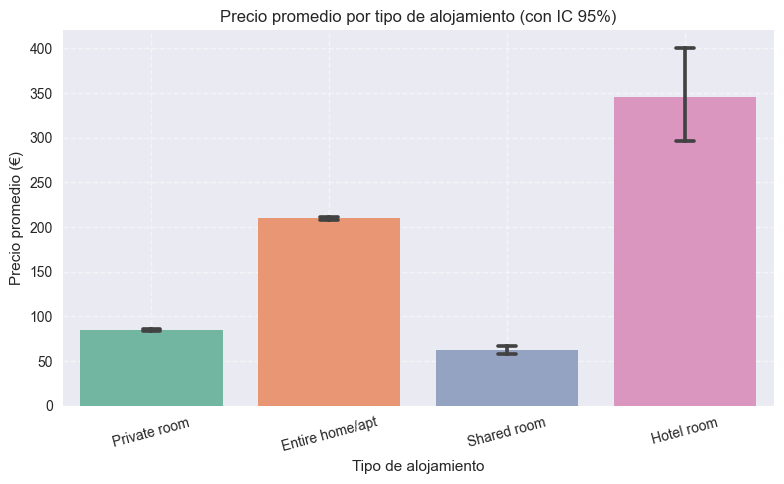

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='room_type', y='price_USD', ci=95, palette='Set2', capsize=0.1)

plt.title('Precio promedio por tipo de alojamiento (con IC 95%)')
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Precio promedio (€)')
plt.xticks(rotation=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Este gráfico:

- Muestra la media del precio por cada tipo de alojamiento.

- Incluye intervalos de confianza del 95% para cada media.

- Refuerza visualmente las diferencias significativas detectadas con ANOVA y Tukey.

### 📊 **Gráfico de barras ordenado por precio promedio**

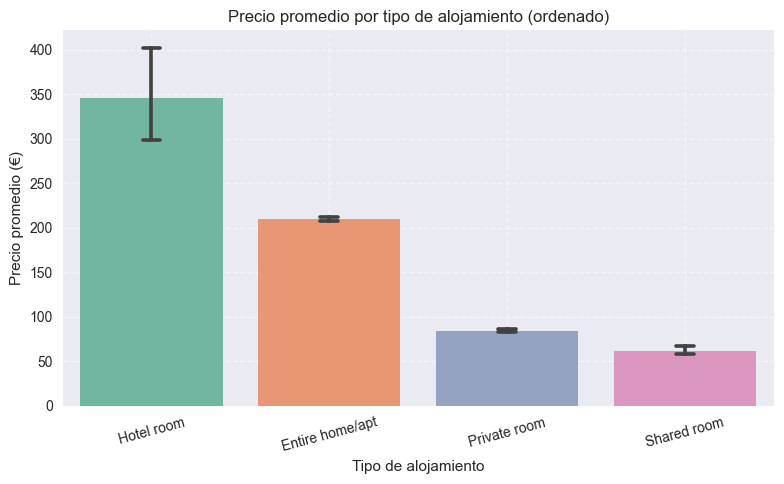

In [75]:
# Calcular medias por tipo de alojamiento
mean_prices = df.groupby('room_type')['price_USD'].mean().sort_values(ascending=False)

# Ordenar los tipos según el precio promedio
order = mean_prices.index.tolist()

# Gráfico ordenado
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='room_type', y='price_USD', order=order, ci=95, palette='Set2', capsize=0.1)

plt.title('Precio promedio por tipo de alojamiento (ordenado)')
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Precio promedio (€)')
plt.xticks(rotation=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Este gráfico muestra:

👉 De izquierda a derecha: el alojamiento más caro al más barato.

👉 Con intervalos de confianza visibles para reforzar las diferencias estadísticas.

Esta hipótesis analiza si el tipo de alojamiento (habitaciones privadas, compartidas, apartamentos completos o habitaciones de hotel) tiene un impacto significativo en el precio de los alojamientos en Madrid.

Para ello, se realizó un análisis ANOVA, el cual arrojó un resultado altamente significativo (F = 2970.78, p = 0.0000), indicando que existen diferencias significativas en los precios medios según el tipo de alojamiento.

Posteriormente, se aplicó la prueba post-hoc de Tukey HSD, que confirmó que todas las comparaciones entre grupos son estadísticamente significativas (p < 0.05). Es decir, cada tipo de alojamiento tiene un precio promedio distinto al de los demás, con diferencias que van desde los 22 € hasta más de 280 €.

El gráfico de barras con los precios promedio y sus intervalos de confianza refuerza visualmente estos hallazgos. En él se observa que:

Las habitaciones de hotel son, en promedio, las más caras.

Les siguen los apartamentos completos.

Luego las habitaciones privadas.

Finalmente, las habitaciones compartidas, que son las más económicas.

#### ✅ Conclusión:
**Se acepta la hipótesis H4. El tipo de alojamiento influye significativamente en el precio de los alojamientos en Madrid.**

**Valores principales (1.0):**
- Correlación perfecta en diagonal (cada tipo consigo mismo)
- **Entire home/apt** y **Hotel room** correlacionados perfectamente
- **Entire home/apt** y **Hotel room** tienen correlación perfecta (1.0), lo que sugiere que estos dos tipos de alojamiento tienen patrones muy similares en los datos

**Valores muy pequeños (≈0):**
- Correlaciones prácticamente nulas entre la mayoría de tipos
- Indica comportamientos independientes
- Los números como `4.142867461544113e-42` son esencialmente **cero** (números extremadamente pequeños en notación científica)

**Valor intermedio**
- `0.0004328...` también es muy cercano a cero, indicando correlación muy débil

### Agrupación identificada:
- **Grupo 1**: Entire home/apt + Hotel room (privacidad completa)
- **Grupo 2**: Private room + Shared room (alojamientos compartidos)



### Conclusiones H4

 SÍ, el tipo de alojamiento influye significativamente en el precio

- El gráfico confirma visualmente que el tipo de alojamiento SÍ influye en el precio, especialmente en términos de:

- Rango de precios (variabilidad)
- Concentración de datos
- Presencia de valores extremos

Esto explica perfectamente por qué el test Kruskal-Wallis dio un resultado tan significativo (H=6173.06)!

### Resumen del Análisis de Airbnb en Madrid

En este estudio se analizaron diversas hipótesis relacionadas con los precios de los alojamientos en Airbnb en Madrid, utilizando técnicas estadísticas y visualizaciones para validar las relaciones entre variables clave. A continuación, se presentan los hallazgos principales:

---

#### **H1: ¿Los alojamientos con alta disponibilidad tienen mayor precio promedio?**
- **Hallazgo:** Los alojamientos con alta disponibilidad (≥180 días) tienden a tener precios más altos. Esto puede deberse a estrategias de pricing donde los propietarios fijan precios elevados para maximizar ingresos con pocas reservas.
- **Conclusión:** La hipótesis se acepta parcialmente, ya que existe una diferencia significativa en los precios según la disponibilidad.

---

#### **H2: ¿Existen diferencias de precio entre barrios?**
- **Hallazgo:** Los precios varían significativamente entre barrios. Retiro, Centro y Arganzuela destacan como zonas premium con precios más altos, mientras que barrios periféricos como Chamartín y Latina tienen precios más bajos.
- **Conclusión:** La hipótesis se acepta completamente, confirmando que la ubicación geográfica influye en los precios.

---

#### **H3: ¿Los alojamientos con más reviews son más caros?**
- **Hallazgo:** No se encontró evidencia estadística significativa que relacione la cantidad de reviews con el precio. Aunque los alojamientos con más reviews tienden a ser más económicos, las diferencias observadas son atribuibles a la variabilidad natural.
- **Conclusión:** La hipótesis se rechaza, indicando que la popularidad medida por reviews no determina el precio.

---

#### **H4: ¿El tipo de alojamiento influye en el precio?**
- **Hallazgo:** El tipo de alojamiento tiene un impacto significativo en el precio. Las habitaciones de hotel son las más caras, seguidas por apartamentos completos, habitaciones privadas y habitaciones compartidas.
- **Conclusión:** La hipótesis se acepta completamente, mostrando que el nivel de privacidad y comodidad influye en las tarifas.

---

### Implicaciones Prácticas
- **Para anfitriones:** Ajustar precios según ubicación, tipo de alojamiento y estrategias de disponibilidad puede maximizar ingresos.
- **Para huéspedes:** Elegir el barrio y tipo de alojamiento adecuado puede optimizar costos.
- **Para inversores:** Identificar zonas premium y tipos de alojamiento con mayor rentabilidad es clave para decisiones estratégicas.

Este análisis refuerza la importancia de entender las dinámicas del mercado de Airbnb en Madrid, destacando cómo factores como ubicación, disponibilidad y tipo de alojamiento afectan los precios.